In [ ]:
ImageDataGenerator

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, json, os, random 
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.preprocessing.image import load_img 
import tensorflow as tf
import shutil
import wandb

2022-10-03 05:39:24.961026: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Setting seed

In [24]:
len(new_img_paths)

37407

In [25]:
data_df['Organized_img_path'] = new_img_paths

In [26]:
data_df.head(5)

,Image file,Medium,Museum,Museum-based instance ID,Subset,Width,Height,Product size,Aspect ratio,Organized_img_path
0,436018.jpg,Oil on canvas,Metropolitan Museum of Art,29.100.60,train,3144.0,3840.0,12072960.0,0.8187,./data/train/Oil on canvas/436018.jpg
1,11779.jpg,Oil on canvas,Metropolitan Museum of Art,1982.373,train,1707.0,2136.0,3646152.0,0.7992,./data/train/Oil on canvas/11779.jpg
2,19022.jpg,Oil on canvas,Metropolitan Museum of Art,2006.418,train,2845.0,3811.0,10842295.0,0.7465,./data/train/Oil on canvas/19022.jpg
3,435883.jpg,Oil on canvas,Metropolitan Museum of Art,61.101.3,train,3811.0,2916.0,11112876.0,1.3069,./data/train/Oil on canvas/435883.jpg
4,10481.jpg,Oil on canvas,Metropolitan Museum of Art,09.95,train,3811.0,2099.0,7999289.0,1.8156,./data/train/Oil on canvas/10481.jpg


In [29]:
data_df.to_csv('Organized_MAMe_dataset.csv')

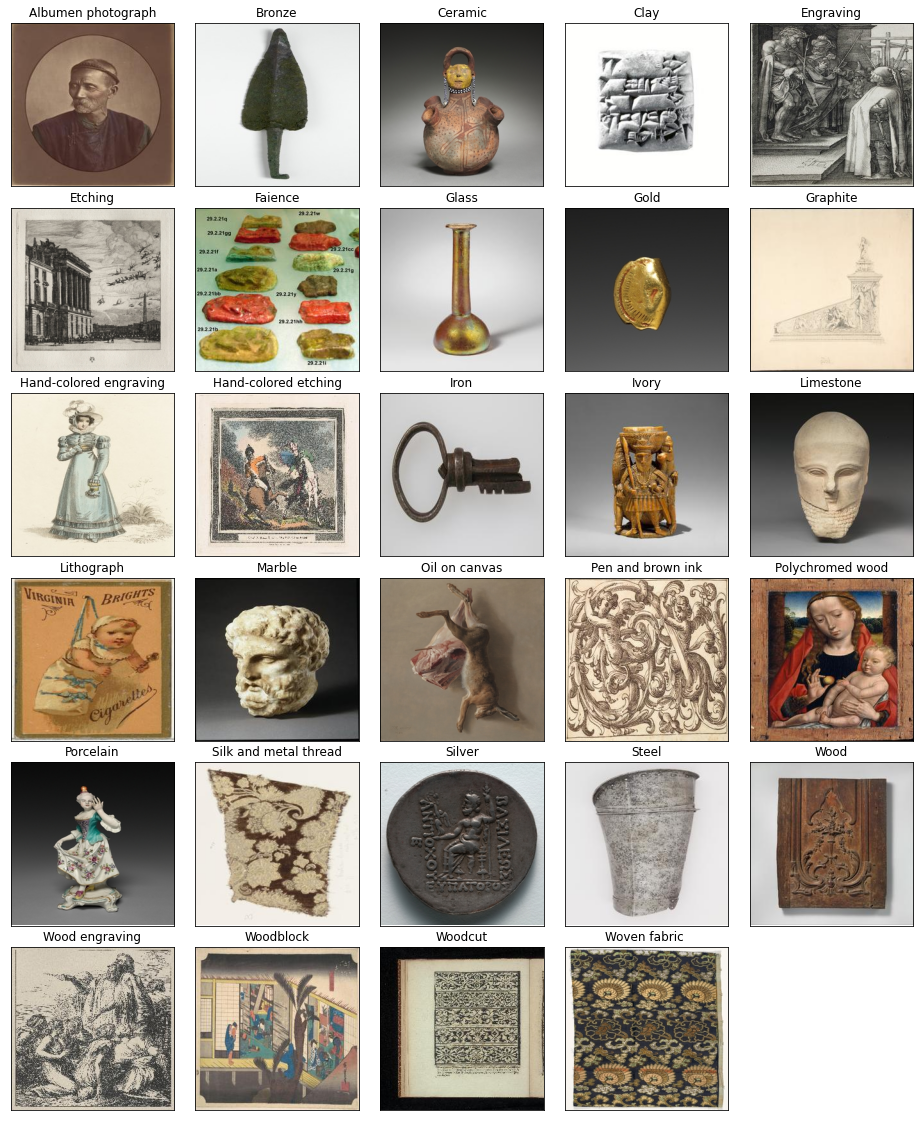

In [30]:
fig = plt.figure(figsize=(20.,20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
)

for ax, medium in zip(grid, list(np.unique(data_df.Medium))):
    filepath = data_df[data_df.Medium == medium].sample(1).Organized_img_path.values[0]
    img = load_img(filepath)
    ax.imshow(img)
    ax.title.label = "hi"
    ax.set_title(medium)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

grid[-1].remove()

plt.show()

## Building Model

#### Difference tensorflow.keras and keras??

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, json, os, random 
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.preprocessing.image import load_img 
import tensorflow as tf
import shutil
import wandb

2022-10-03 05:52:13.517181: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import time
# import keras
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import np_utils

In [3]:
seed = 168 
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    # tf.set_random_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(seed)

Random seed set as 168


In [4]:
train_folder = './data/train' 
val_folder = './data/test' 
test_folder = './data/val' 

In [5]:
# Initialize some variables
img_height, img_width = 256, 256
num_classes = 29
n_channels = 3
input_shape = (img_height, img_width, n_channels)
batch_size = 128
epochs = 10

In [6]:
X_train = tf.keras.utils.image_dataset_from_directory(
    train_folder, 
    batch_size=batch_size, #  batch_size 
    # image_size=(img_height, img_width), # resize
    shuffle=True,
    seed=seed
)

X_val = tf.keras.utils.image_dataset_from_directory(
    val_folder, 
    batch_size=batch_size, #  batch_size 
    # image_size=(img_height, img_width), # resize
    shuffle=False,    
    # seed=123,
)

X_test = tf.keras.utils.image_dataset_from_directory(
    test_folder, 
    batch_size=batch_size, #  batch_size 
    # image_size=(img_height, img_width), # resize    
    shuffle=False,    
    # seed=123,
)

Found 20300 files belonging to 29 classes.


2022-10-03 05:52:21.788113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 05:52:22.411522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:8a:00.0, compute capability: 8.6


Found 15657 files belonging to 29 classes.
Found 1450 files belonging to 29 classes.


In [7]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.0


In [10]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=input_shape, data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation=(tf.nn.softmax)))

# Print model summary
# print(model.summary())

## Adding wandb Callback

In [11]:
wandb.init()
wandb_callback = wandb.keras.WandbCallback()

wandb: Currently logged in as: summerzhang. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
# Launch 20 experiments, trying different dropout rates
for run in range(20):
  # Start a run, tracking hyperparameters
wandb.init(
      project="keras-intro",
      # Set entity to specify your username or team name
      # ex: entity="wandb",
      config={
          "layer_1": 512,
          "activation_1": "relu",
          "dropout": random.uniform(0.01, 0.80),
          "layer_2": 10,
          "activation_2": "softmax",
          "optimizer": "sgd",
          "loss": "sparse_categorical_crossentropy",
          "metric": "accuracy",
          "epoch": 6,
          "batch_size": 256
      })
    config = wandb.config


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(lr=0.001, epsilon=0.1, amsgrad=True), metrics=["accuracy"])
# Use early stopping
early = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto', restore_best_weights=True)

# Train the model 
t0 = time.time()
epochs = 100

t0 = time.time()
    
history = model.fit( X_train,
          validation_data=X_val,
          epochs=epochs, 
          callbacks=[logging_callback]                    
)
    
print('Model trained in {:.1f}min'.format((time.time()-t0)/60))

Epoch 1/100


2022-10-03 05:57:56.022047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-03 05:57:58.257300: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


159/159 [==============================] - 24s 116ms/step - loss: 3.3442 - accuracy: 0.0469 - val_loss: 3.3226 - val_accuracy: 0.0562
Epoch 2/100
159/159 [==============================] - 18s 113ms/step - loss: 3.2785 - accuracy: 0.0814 - val_loss: 3.2242 - val_accuracy: 0.1066
Epoch 3/100
159/159 [==============================] - 18s 115ms/step - loss: 3.0844 - accuracy: 0.1478 - val_loss: 2.9574 - val_accuracy: 0.1687
Epoch 4/100
159/159 [==============================] - 18s 115ms/step - loss: 2.8087 - accuracy: 0.2261 - val_loss: 2.6641 - val_accuracy: 0.2582
Epoch 5/100
159/159 [==============================] - 18s 114ms/step - loss: 2.4562 - accuracy: 0.3140 - val_loss: 2.3160 - val_accuracy: 0.3372
Epoch 6/100
159/159 [==============================] - 18s 114ms/step - loss: 2.2095 - accuracy: 0.3666 - val_loss: 2.1909 - val_accuracy: 0.3604
Epoch 7/100
159/159 [==============================] - 18s 115ms/step - loss: 2.0587 - accuracy: 0.3979 - val_loss: 2.1172 - val_accurac

## Evaluate the Model

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

def evaluate_model(model, eval_gen):
    """ Evaluate given model and print results.
    Show validation loss and accuracy, classification report and 
    confusion matrix.

    Args:
        model (model): model to evaluate
        eval_gen (ImageDataGenerator): evaluation generator
    """
    # Evaluate the model
    eval_gen.reset()
    score = model.evaluate(eval_gen, verbose=0)
    print('\nLoss:', score[0])
    print('Accuracy:', score[1])
    
    # Confusion Matrix (validation subset)
    eval_gen.reset()
    pred = model.predict(eval_gen, verbose=0)

    # Assign most probable label
    predicted_class_indices = np.argmax(pred,axis=1)

    # Get class labels
    labels = (eval_gen.class_indices)
    target_names = labels.keys()

    # Plot statistics
    print(classification_report(eval_gen.classes, predicted_class_indices, target_names=target_names))

    cf_matrix = confusion_matrix(np.array(eval_gen.classes), predicted_class_indices)
    fig, ax = plt.subplots(figsize=(13, 13)) 
    sns.heatmap(cf_matrix, annot=True, cmap='PuRd', cbar=False, square=True, xticklabels=target_names, yticklabels=target_names)
    plt.show()
    
evaluate_model(model, validation_generator)